# boosted_logit

In [92]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.ensemble         import AdaBoostClassifier

from sklearn.linear_model     import LogisticRegression

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [93]:
SEED   = 97

scale  = False 
minmax = False
norm   = False
nointercept = False
engineering = True

submission_filename = "../submissions/submission_boosted_logit_lbfgs.csv"

# Load the training data

In [94]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [95]:
#%%time

random.seed(SEED)
 
# ---------------------------------- base estimator ------------------------------------------------
base = LogisticRegression(penalty           = 'l2',          
                         dual              = False, 
                         C                 = 0.001, 
                         fit_intercept     = True,
                         solver            = 'lbfgs',   
                         max_iter          = 100, 
                         intercept_scaling = 1,
                         
                         tol               = 0.0001, 
                         class_weight      = None, 
                         random_state      = SEED, 
                         multi_class       = 'ovr', 
                         verbose           = 0, 
                         warm_start        = False, 
                         n_jobs            = 1)

# ---------------------------------- AdaBoostClassifier ------------------------------------------------
clf = AdaBoostClassifier(base_estimator = base, 
                         n_estimators   = 50, 
                         learning_rate  = 1.0, 
                         algorithm      = 'SAMME.R', 
                         random_state   = SEED)
    


StatifiedCV = StratifiedKFold(y            = y_train, 
                              n_folds      = 10, 
                              shuffle      = True, 
                              random_state = SEED)

param_grid = dict(n_estimators  = [25, 50, 75, 100],
                  learning_rate = [0.001, 0.01, 0.1, 1.0],
                  algorithm     = ['SAMME','SAMME.R'])
                  #base__solver  = ['newton-cg', 'lbfgs' 'sag']) 

grid_clf = GridSearchCV(estimator  = clf, 
                        param_grid = param_grid,
                        n_jobs     = -1,  
                        cv         = StatifiedCV).fit(X_train, y_train)

print("clf_params = {}".format(grid_clf.best_params_))
print("score: {}".format(grid_clf.best_score_))

clf = grid_clf.best_estimator_




# clf_params = {'n_estimators': 25, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}
# clf.set_params(**clf_params)
# clf.fit(X_train, y_train)

clf_params = {'n_estimators': 75, 'learning_rate': 0.1, 'algorithm': 'SAMME'}
score: 0.776041666667


In [96]:
# from sklearn_utilities import GridSearchHeatmap

# GridSearchHeatmap(grid_clf, y_key='C', x_key='gamma')

# from sklearn_utilities import plot_validation_curves

# plot_validation_curves(grid_clf, param_grid, X_train, y_train, ylim = (0.0, 1.05))

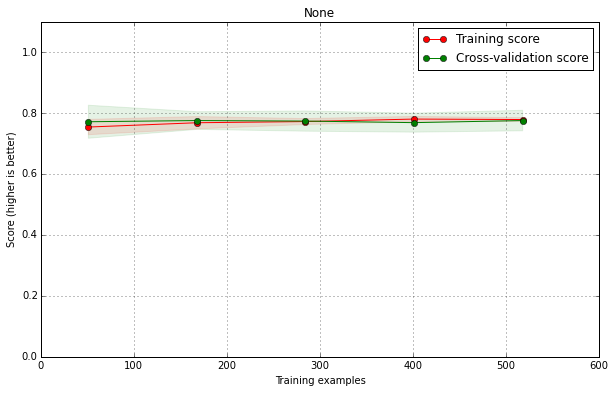

CPU times: user 292 ms, sys: 48 ms, total: 340 ms
Wall time: 3.5 s


In [97]:
%%time

try:
    from sklearn_utilities import plot_learning_curve
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_learning_curve
    

plot_learning_curve(estimator   = clf, 
                    title       = None, 
                    X           = X_train, 
                    y           = y_train, 
                    ylim        = (0.0, 1.10), 
                    cv          = StratifiedKFold(y            = y_train, 
                                                  n_folds      = 10, 
                                                  shuffle      = True, 
                                                  random_state = SEED), 
                    train_sizes = np.linspace(.1, 1.0, 5),
                    n_jobs      = -1)

plt.show()

# Training set predictions

In [98]:
predicted_values = clf.predict(X_train)
y_true, y_pred   = y_train, predicted_values

predicted_probs  = clf.predict_proba(X_train)

[[418  20]
 [108  30]]


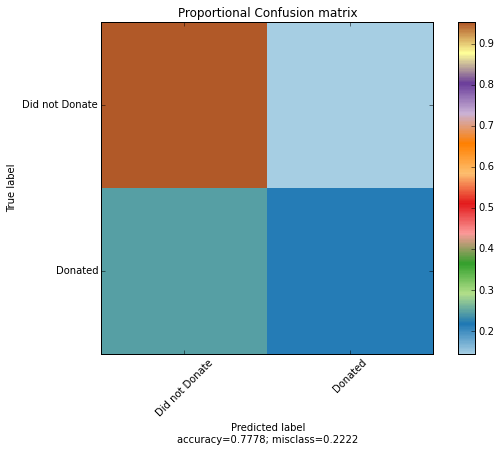

Accuracy 0.7778, mis-class rate 0.2222


In [99]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix


plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy, misclass))

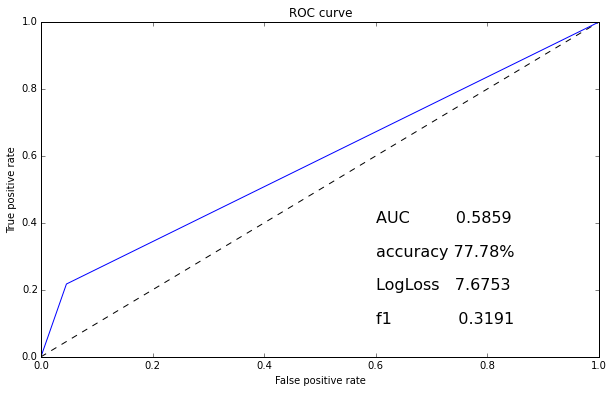

In [100]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1             {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

# ----------------------------------------------------------------------------------------

# Test Set Predictions

## Load the test data

In [101]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [102]:
y_pred        = clf.predict(X_test)
y_pred_probs  = clf.predict_proba(X_test)
donate_probs  = [prob[1] for prob in y_pred_probs]

In [103]:
print(y_pred[:10])
print(y_pred_probs[:10])
print(donate_probs[:10])

[1 0 0 0 1 1 0 0 0 0]
[[ 0.48735838  0.51264162]
 [ 0.6308336   0.3691664 ]
 [ 0.54822552  0.45177448]
 [ 0.55355365  0.44644635]
 [ 0.49286856  0.50713144]
 [ 0.42972522  0.57027478]
 [ 0.5417354   0.4582646 ]
 [ 0.57710302  0.42289698]
 [ 0.70756789  0.29243211]
 [ 0.65128106  0.34871894]]
[0.51264161984099843, 0.36916640124703048, 0.45177447923016573, 0.44644634839138397, 0.50713143702095154, 0.5702747820578683, 0.45826459969047345, 0.42289697584494379, 0.29243211009081038, 0.34871894113387852]


# Create the submission file

In [104]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()